## In this notebook we compute the effective pressure from the inversion results obtained in the previous notebook

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../source')
sys.path.insert(0, '../scripts')
from shapely.geometry import Point, Polygon
from load_lakes import gdf
import geopandas as gpd


In [2]:
import metavars
metavars.lake_name = 'Cook_E2'        # set to 'synth' or one of the lakes in the inventory
lake_name = metavars.lake_name
dir_name = '../results/IS2_N_'+lake_name
!rm -r {dir_name};
!mkdir {dir_name}

Print the auxiliar parameters (ice thickness, basal drag, viscosity, velocities):

In [3]:
# print the auxiliary model parameters
from print_params import print_params
print_params()
from params import results_dir,data_dir,lamda0,delta,x0,y0,t0,N_sc,rho_w,g

auxiliary model parameters:
H = 2695 m
beta = 7.7e+11 Pa s m^-1
eta = 9.5e+15 Pa s
u = 0.8246221555395972 m yr^-1
v = -0.23137488959856584 m yr^-1
relaxation time = 24.80176270481221 yr


nondimensonal parameters:
lambda = 0.0403
gamma = 0.1091


Choose lake boundary:

In [4]:
poly_list = []
outlines = gpd.GeoSeries(poly_list)
outline_prev = gdf.loc[gdf['name']==lake_name]
h_obs = np.load(data_dir+'/h_obs.npy')


%matplotlib tk
x_d = np.load(data_dir+'/x_d.npy')
y_d = np.load(data_dir+'/y_d.npy')
i = 70
if lake_name == 'Mac1':
    i=40
fig = plt.figure(figsize=(12,6))
levels= np.linspace(-2,2,6)
ticks= np.linspace(-2,2,6)


plt.title(r'choose lake boundary!',fontsize=20)
p = plt.contourf(x_d,y_d,h_obs[i,:,:],levels=levels,cmap='PuOr_r',extend='both')
outline_prev.plot(edgecolor='gray',linestyle='-',facecolor='none',ax=plt.gca(),linewidth=4)
if outlines.size>0:
    outlines.plot(edgecolor='k',facecolor='none',ax=plt.gca(),linewidth=3)
plt.xlabel(r'$x$ (km)',fontsize=20)
plt.ylabel(r'$y$ (km)',fontsize=20)
cbar = plt.colorbar(p,ticks=ticks,orientation='horizontal', fraction=0.05, pad=0.15)
cbar.ax.tick_params(labelsize=14)   
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar.set_label(r'$\Delta h$ (m)', fontsize=20)
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
pts = plt.ginput(-1,timeout=-1)
poly_list.append(Polygon(pts))
outlines = gpd.GeoSeries(poly_list)
outlines.plot(edgecolor='k',facecolor='none',ax=plt.gca(),linewidth=3)
plt.pause(2)
plt.close()
outline = outlines[0]

# define numpy array for boundary
x_d = np.load(data_dir+'/x_d.npy')
y_d = np.load(data_dir+'/y_d.npy')
xp,yp = np.meshgrid(x_d,y_d)
bdry = 0*xp 
for i in range(x_d.size):
    for j in range(y_d.size):
        point = Point(x_d[i],y_d[j])
        bdry[j,i] = outline.contains(point)

Calculate the effective pressure!

In [5]:
from kernel_fcns import fftd,ifftd,C_h,C_w
from post_process import calc_s

# load elevation data (h_obs)
h = np.load(results_dir+'/h_fwd.npy')
w = np.load(results_dir+'/w_inv.npy')
s = calc_s(w,initial=0) + h[0,:,:]

s_mean = np.zeros(s.shape[0])
for i in range(s.shape[0]):
    s_i = s[i,:,:]
    s_mean[i] = s_i[bdry>1e-2].mean()

h_ft = fftd(h)
w_ft = fftd(w)
N_ft = (1/lamda0)*C_w()*w_ft - C_h()*h_ft 
N = ifftd(N_ft).real + delta*((s.T -s_mean.T).T)*bdry

np.save(dir_name+'/N.npy',N)
np.save(dir_name+'/w.npy',w)
np.save(dir_name+'/h.npy',h)
np.save(dir_name+'/x.npy',x0)
np.save(dir_name+'/y.npy',y0)
np.save(dir_name+'/t.npy',t0)

Calculate means over the lake:

In [6]:
def get_means(N,w,h,bdry):
    N_mean = np.zeros(N.shape[0])
    w_mean = np.zeros(w.shape[0])
    h_mean = np.zeros(h.shape[0])

    for i in range(N.shape[0]):
        N_i = N[i,:,:]
        w_i = w[i,:,:]
        h_i = h[i,:,:]

        N_mean[i] = N_i[bdry>1e-2].mean()
        w_mean[i] = w_i[bdry>1e-2].mean()
        h_mean[i] = h_i[bdry>1e-2].mean()
    return N_mean, w_mean, h_mean   

N_mean, w_mean, h_mean   = get_means(N,w,h,bdry)
np.save(dir_name+'/N_mean.npy',N_mean)
np.save(dir_name+'/w_mean.npy',w_mean)
np.save(dir_name+'/h_mean.npy',h_mean)
np.save(dir_name+'/bdry.npy',bdry)

Calculate effective pressure at lake boundary:

In [7]:
dx = np.abs(xp[0,1]-xp[0,0])*1e3
bdry_pts_x = np.zeros(0)
bdry_pts_y = np.zeros(0)
bdry_ind = 0*xp
bdry_width = 2000
stride = int(np.ceil(bdry_width/dx))
for i in range(xp.shape[0]):
    for j in range(xp.shape[1]):
        if bdry[j,i]>0 and (bdry[j+stride,i]==0 or bdry[j-stride,i]==0 or bdry[j,i+stride]==0 or bdry[j,i-stride]==0):
            bdry_ind[j,i] = 1
            bdry_pts_x = np.append(bdry_pts_x, xp[j,i])
            bdry_pts_y = np.append(bdry_pts_y, yp[j,i])


N_bdry = np.zeros(N.shape[0])
for i in range(N.shape[0]):
    N_bdry[i] = np.mean(N[i,:,:][bdry_ind>1e-2])

Plot figure:

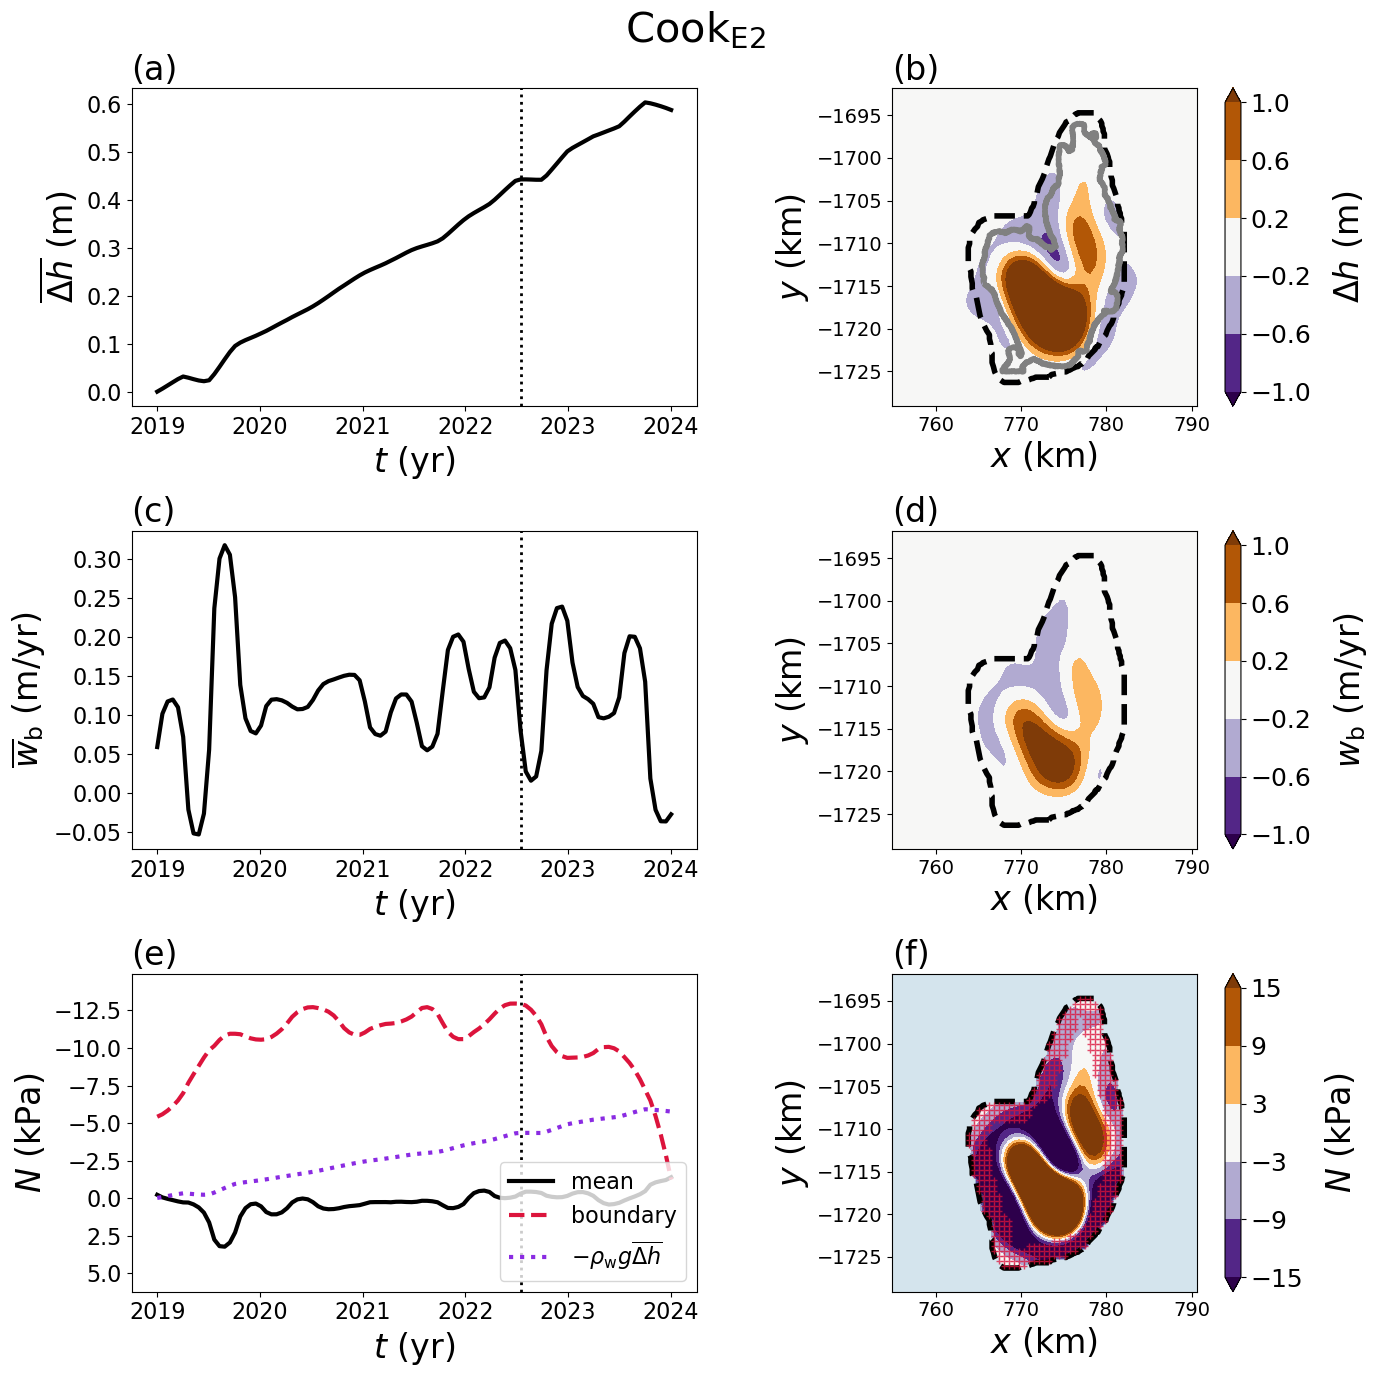

In [9]:
%matplotlib inline

xp,yp = np.meshgrid(x_d,y_d)

if lake_name == 'Mac1':
    l=25
    levels_h = np.linspace(-2,2,6)
    levels_w = np.linspace(-2,2,6)
    levels_N = np.linspace(-15,15,6)
    name_str = r'Mac1'
    figname = 'fig8'
    legend_loc = 'lower right'
elif lake_name == 'MercerSubglacialLake':
    l=70
    levels_h = np.linspace(-2,2,6)
    levels_w = np.linspace(-2,2,6)
    levels_N = np.linspace(-10,10,6)
    name_str = r'Mercer Subglacial Lake'
    figname = 'fig7'
    legend_loc = 'upper left'
elif lake_name == 'Byrd_s10':
    l = 40    
    levels_h = np.linspace(-1,1,6)
    levels_w = np.linspace(-1,1,6)
    levels_N = np.linspace(-25,25,6)
    name_str = r'Byrd$_{\mathrm{s}10}$'
    figname = 'fig10'
    legend_loc = 'lower left'
elif lake_name == 'Cook_E2':
    l = 70
    levels_h = np.linspace(-1,1,6)
    levels_w = np.linspace(-1,1,6)
    levels_N = np.linspace(-15,15,6)
    name_str = r'Cook$_{\mathrm{E}2}$'
    figname = 'fig9'
    legend_loc = 'lower right'

pads_x = 3
pads_y = 3
if lake_name == 'Cook_E2':
    pads_x *= 3
elif lake_name == "Byrd_s10":
    pads_x *= 1.5    
j0 = int(0.0*t0.size)
N_est = -rho_w*g*h_mean
N_max = np.max( [N_est[j0:None]/N_sc,N_bdry[j0:None], N_mean[j0:None]])*N_sc/1e3 + 3
N_min = np.min( [N_est[j0:None]/N_sc,N_bdry[j0:None], N_mean[j0:None]])*N_sc/1e3 - 2

plt.figure(figsize=(14,14))
plt.subplot(321)
plt.suptitle(name_str,fontsize=30)
plt.title('(a)',loc='left',fontsize=24)
plt.plot(t0[j0:None]+2019,h_mean[j0:None],color='k',linewidth=3,label=r'$\overline{\Delta h}$ (m)')
plt.axvline(x=t0[l]+2019,color='k',linestyle=':',linewidth=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$t$ (yr)',fontsize=24)

plt.ylabel(r'$\overline{\Delta h}$ (m)',fontsize=24)
# plt.gca().xaxis.set_ticklabels([])

plt.subplot(323)
plt.title('(c)',loc='left',fontsize=24)
plt.plot(t0[j0:None]+2019,w_mean[j0:None],color='k',linewidth=3,label=r'$\overline{w}_\mathrm{b}$ (m/yr)')
plt.axvline(x=t0[l]+2019,color='k',linestyle=':',linewidth=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$t$ (yr)',fontsize=24)

plt.ylabel(r'$\overline{w}_\mathrm{b}$ (m/yr)',fontsize=24)
# plt.gca().xaxis.set_ticklabels([])

plt.subplot(325)
plt.title('(e)',loc='left',fontsize=24)
plt.plot(t0[j0:None]+2019,N_mean[j0:None]*N_sc/1e3,color='k',linewidth=3,label=r'mean')
plt.plot(t0[j0:None]+2019,N_bdry[j0:None]*N_sc/1e3,color='crimson',linestyle='--',linewidth=3,label=r'boundary')
plt.plot(t0[j0:None]+2019,N_est[j0:None]/1e3,color='blueviolet',linestyle=':',linewidth=3,label=r'$-\rho_\mathrm{w}g\overline{\Delta h}$')
plt.axvline(x=t0[l]+2019,color='k',linestyle=':',linewidth=2)
plt.ylabel(r'$N$ (kPa)',fontsize=24)
plt.xlabel(r'$t$ (yr)',fontsize=24)
lgd = plt.legend(fontsize=16,ncol=1,loc=legend_loc)
plt.ylim(N_max,N_min)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.subplot(322)
plt.title('(b)',loc='left',fontsize=24)
p = plt.contourf(xp,yp,h[l,:,:],cmap='PuOr_r',levels=levels_h,extend='both')
outline = gpd.GeoSeries(outlines[0])
outline.plot(edgecolor='k',linestyle='--',facecolor='none',ax=plt.gca(),linewidth=4)
outline_prev.plot(edgecolor='gray',linestyle='-',facecolor='none',ax=plt.gca(),linewidth=4)
cbar = plt.colorbar(p,orientation='vertical')
cbar.set_label(r'$\Delta h$ (m)',fontsize=24,labelpad=15)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().set_aspect('equal', 'box')
plt.xlabel(r'$x$ (km)',fontsize=24)
plt.ylabel(r'$y$ (km)',fontsize=24)
plt.xlim(bdry_pts_x.min()-pads_x,bdry_pts_x.max()+pads_x)
plt.ylim(bdry_pts_y.min()-pads_y,bdry_pts_y.max()+pads_y)

plt.subplot(324)
plt.title('(d)',loc='left',fontsize=24)
p = plt.contourf(xp,yp,w[l,:,:],cmap='PuOr_r',levels=levels_w,extend='both')
outline = gpd.GeoSeries(outlines[0])
outline.plot(edgecolor='k',linestyle='--',facecolor='none',ax=plt.gca(),linewidth=4)
# outline_prev.plot(edgecolor='gray',linestyle='-',facecolor='none',ax=plt.gca(),linewidth=4)
cbar = plt.colorbar(p,orientation='vertical')
cbar.set_label(r'$w_\mathrm{b}$ (m/yr)',fontsize=24,labelpad=15)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$x$ (km)',fontsize=24)
plt.ylabel(r'$y$ (km)',fontsize=24)

plt.xlim(bdry_pts_x.min()-pads_x,bdry_pts_x.max()+pads_x)
plt.ylim(bdry_pts_y.min()-pads_y,bdry_pts_y.max()+pads_y)

plt.gca().set_aspect('equal', 'box')

plt.subplot(326)
plt.title('(f)',loc='left',fontsize=24)
p = plt.contourf(xp,yp,bdry*N[l,:,:]*N_sc/1e3,cmap='PuOr_r',levels=levels_N,extend='both')
plt.contourf(xp,yp,bdry,cmap='Blues_r',levels=[0,0.9],alpha=0.25)#,hatches=['\\',''],alpha=0.25)
outline = gpd.GeoSeries(outlines[0])
outline.plot(edgecolor='k',linestyle='--',facecolor='none',ax=plt.gca(),linewidth=4)
# outline_prev.plot(edgecolor='gray',linestyle='-',facecolor='none',ax=plt.gca(),linewidth=4)
plt.plot(bdry_pts_x,bdry_pts_y,'+',color='crimson',alpha=0.75,markersize=5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(bdry_pts_x.min()-pads_x,bdry_pts_x.max()+pads_x)
plt.ylim(bdry_pts_y.min()-pads_y,bdry_pts_y.max()+pads_y)
plt.xlabel(r'$x$ (km)',fontsize=24)
plt.ylabel(r'$y$ (km)',fontsize=24)
plt.gca().set_aspect('equal', 'box')

cbar = plt.colorbar(p,orientation='vertical')
cbar.set_label(r'$N$ (kPa)',fontsize=24,labelpad=15)
cbar.ax.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig(figname)      
plt.show()
plt.close()